# <font color='#1a5276'> <b> <center> Dropout </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Example 1](#3) <br>
    3.1. [Data](#3.1) <br>
    3.2. [Model architecture and training](#3.2) <br>
    3.3. [Model comparisson](#3.3) <br>
4. [Example 2](#4) <br>
    4.1. [Helper Functions](#4.1) <br>
    4.2. [Data](#4.2) <br>
    4.3. [Model architecture, training and evaluation](#4.3) <br>
5. [Annex](#annex)
6. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction of the input units to zero during training. This encourages the network to learn robust features and improves generalization.

This notebook demonstrates the concept of dropout in neural networks through two examples.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [4]:
# seed
torch.manual_seed(0) 

<a name="3"></a>
## <font color='blue'> <b> 3. Example 1</b> </font>

<a name="3.1"></a>
### <font color='#2471a3'> <b> 3.1. Helper Functions</b> </font>

In [37]:
# plot decision regions
def plot_decision_regions_3class(data_set, model=None):
    """
    Plots the decision regions for a 3-class classification problem and overlays the true decision boundary.

    Parameters:
    - data_set: An object containing the dataset, expected to have `x`, `y`, and `multi_dim_poly` attributes.
                `x` and `y` are assumed to be numpy-like arrays for features and labels.
                `multi_dim_poly` is a function that computes the decision boundary.
    - model: (Optional) A PyTorch model. If provided, the model's predictions are used to generate the decision regions.

    Returns:
    - None: Displays the plot of decision regions and the true decision boundary.
    """
    # Define color maps for plotting the regions and boundaries
    cmap_light = ListedColormap(['#0000FF', '#FF0000'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    
    # Extract feature and label data from the dataset
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    
    # Define the resolution for the mesh grid
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    
    # Create a mesh grid over the feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    newdata = np.c_[xx.ravel(), yy.ravel()]
    
    # Compute the true decision boundary using the dataset's polynomial function
    Z = data_set.multi_dim_poly(newdata).flatten()
    f = np.zeros(Z.shape)
    f[Z > 0] = 1
    f = f.reshape(xx.shape)
    
    if model != None:
        # If a model is provided, evaluate its predictions
        model.eval()
        XX = torch.Tensor(newdata)
        _, yhat = torch.max(model(XX), 1)
        yhat = yhat.numpy().reshape(xx.shape)
        
        # Plot the model's decision regions
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        # Overlay the true decision boundary
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        # Plot only the true decision boundary
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light)

    # Add a title to the plot
    plt.title("decision region vs True decision boundary")

    
# calculate accuracy
def accuracy(model, dataset):
    _, yhat = torch.max(model(dataset.x), 1)
    return (yhat == dataset.y).numpy().mean()

<a name="3.2"></a>
### <font color='#2471a3'> <b> 3.2. Data </b> </font>

We will create a non-linearly separable dataset.

In [21]:
# Create data class for creating dataset object
class Data(Dataset):
    """
    A custom dataset class for generating synthetic data for binary classification tasks.
    This dataset includes features, labels, and noise for training and testing purposes.

    Attributes:
    - x: Features of the dataset (torch.FloatTensor).
    - y: Labels of the dataset (torch.LongTensor).
    - f: True decision function values (torch.FloatTensor).
    - a: Coefficients used for generating the data (numpy matrix).

    Methods:
    - __getitem__(index): Retrieves a single sample (feature, label) by index.
    - __len__(): Returns the total number of samples in the dataset.
    - plot(): Plots the data points and the true decision boundary.
    - multi_dim_poly(x): Computes the polynomial decision boundary for given input `x`.
    """

    # Constructor
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        """
        Initializes the dataset with a specified number of samples, noise level, and training flag.

        Parameters:
        - N_SAMPLES: Number of samples to generate (default: 1000).
        - noise_std: Standard deviation of noise to add to the features (default: 0.15).
        - train: Boolean indicating if the dataset is for training (default: True).
        """
        # Define coefficients for the polynomial function
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        
        # Generate random feature data
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        
        # Compute the true decision function
        self.f = np.array(
            a[0] + (self.x) * a[1:3] + 
            np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + 
            np.multiply(self.x, self.x) * a[5:7]
        ).flatten()
        self.a = a
        
        # Generate labels based on the decision function
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        
        # Convert features to PyTorch tensors and add noise
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        
        if train:
            # Add additional noise for training datasets
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
    
    # Getter
    def __getitem__(self, index):    
        """
        Retrieves the feature and label at a given index.

        Parameters:
        - index: The index of the sample to retrieve.

        Returns:
        - A tuple (feature, label).
        """
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        
        Returns:
        - Length of the dataset.
        """
        return self.len
    
    # Plot the diagram
    def plot(self):
        """
        Plots the data points with noise and overlays the true decision boundary.
        """
        X = self.x.numpy()
        y = self.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = self.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary and sample points with noise')
        plt.scatter(self.x[y == 0, 0].numpy(), self.x[y == 0, 1].numpy(), c='blue', label='y=0', edgecolors='k') 
        plt.scatter(self.x[y == 1, 0].numpy(), self.x[y == 1, 1].numpy(), c='red', label='y=1', edgecolors='k')
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.legend()
        
        
    # Make a multidimension polynomial function
    def multi_dim_poly(self, x):
        """
        Computes the polynomial decision boundary for the given input.

        Parameters:
        - x: Input data (numpy array or matrix).

        Returns:
        - The computed decision boundary values.
        """
        x = np.matrix(x)
        out = np.array(
            self.a[0] + (x) * self.a[1:3] + 
            np.multiply(x[:, 0], x[:, 1]) * self.a[4] + 
            np.multiply(x, x) * self.a[5:7]
        )
        return np.array(out)


In [22]:
# dataset for training
train_dataset = Data(noise_std = 0.2)

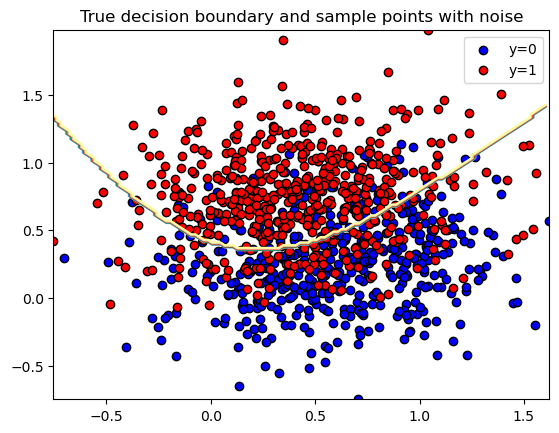

In [23]:
# plot
train_dataset.plot()

In [24]:
# validation data
val_dataset = Data(train=False)

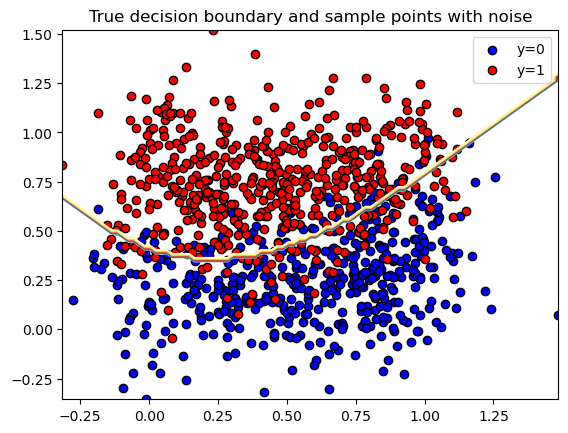

In [25]:
# plot
val_dataset.plot()

<a name="3.3"></a>
### <font color='#2471a3'> <b> 3.3. Model and training </b> </font>

### Results

In [26]:
# To store results
loss = {}
loss['training data no dropout'] = []
loss['validation data no dropout'] = []
loss['training data dropout'] = []
loss['validation data dropout'] = []

### Model definition

In [27]:
class Net(nn.Module):
    """
    A neural network model with dropout.

    Attributes:
    - linear1 (nn.Linear): First fully connected layer.
    - linear2 (nn.Linear): Second fully connected layer.
    - linear3 (nn.Linear): Third fully connected layer (output layer).
    - drop (nn.Dropout): Dropout layer for regularization.

    Methods:
    - forward(x): Defines the forward pass of the network, applying layers in sequence with activation and dropout.
    """

    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
        """
        Initializes the network with input size, hidden layer size, output size, and dropout probability.

        Parameters:
        - in_size (int): Number of input features.
        - n_hidden (int): Number of neurons in the hidden layers.
        - out_size (int): Number of output features.
        - p (float): Dropout probability (default: 0, no dropout).
        """
        super(Net, self).__init__()
        
        # Dropout layer for regularization
        self.drop = nn.Dropout(p=p)
        
        # Fully connected layers
        self.linear1 = nn.Linear(in_size, n_hidden)  # Input to first hidden layer
        self.linear2 = nn.Linear(n_hidden, n_hidden)  # First hidden layer to second hidden layer
        self.linear3 = nn.Linear(n_hidden, out_size)  # Second hidden layer to output layer

    # Forward pass
    def forward(self, x):
        """
        Defines the forward pass of the network.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, in_size).

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, out_size).
        """
        # Apply first linear layer, dropout, and ReLU activation
        x = F.relu(self.drop(self.linear1(x)))
        
        # Apply second linear layer, dropout, and ReLU activation
        x = F.relu(self.drop(self.linear2(x)))
        
        # Apply third linear layer (output layer)
        x = self.linear3(x)
        
        return x


We will create 2 model, one without dropout and the other with a dropout of 0.5:

In [41]:
# model without dropout
model = Net(2, 300, 2)

# model with dropout
model_drop = Net(2, 300, 2, p=0.5)

In [42]:
# set the model with dropout to training mode
model_drop.train()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=2, bias=True)
)

### Optimizers and criterion

In [43]:
# set the optimizers

# model without dropout
optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)

# model with dropout
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)

In [44]:
# criterion
criterion = torch.nn.CrossEntropyLoss()

### Training function

In [45]:
def train_model(model, model_with_dropout, dataset, validation_set, criterion, optimizer, optimizer_with_dropout, epochs, track_dropout=True):
    """
    Trains two models: one with dropout and one without dropout, and tracks their losses.

    Parameters:
    - model: The model without dropout.
    - model_with_dropout: The model with dropout.
    - dataset: Training dataset.
    - validation_set: Validation dataset.
    - criterion: Loss function.
    - optimizer: Optimizer for the model without dropout.
    - optimizer_with_dropout: Optimizer for the model with dropout.
    - epochs: Number of training epochs.
    - track_dropout (bool): Whether to track losses for the dropout model.

    Returns:
    - LOSS: Dictionary containing loss histories for both models.
    """
    # Initialize a dictionary to store losses
    LOSS = {
        'training data no dropout': [],
        'validation data no dropout': []
    }
    if track_dropout:
        LOSS.update({
            'training data dropout': [],
            'validation data dropout': []
        })

    for epoch in range(epochs):
        # Forward pass for the model without dropout
        yhat = model(dataset.x)
        loss = criterion(yhat, dataset.y)

        # Store training loss for the model without dropout
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(
            criterion(model(validation_set.x), validation_set.y).item()
        )

        # Forward pass for the model with dropout (if tracking dropout losses)
        if track_dropout:
            yhat_drop = model_with_dropout(dataset.x)
            loss_drop = criterion(yhat_drop, dataset.y)
            LOSS['training data dropout'].append(loss_drop.item())

            # Evaluate validation loss with model in evaluation mode
            model_with_dropout.eval()
            LOSS['validation data dropout'].append(
                criterion(model_with_dropout(validation_set.x), validation_set.y).item()
            )
            model_with_dropout.train()

        # Backpropagation and optimization for both models
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if track_dropout:
            optimizer_with_dropout.zero_grad()
            loss_drop.backward()
            optimizer_with_dropout.step()

    return LOSS, model, model_with_dropout


In [46]:
losses, model_without_dropout, model_with_dropout = train_model(
    model=model, # without dropout
    model_with_dropout=model_drop,
    dataset=train_dataset,
    validation_set=val_dataset,
    criterion=criterion,
    optimizer=optimizer_ofit,
    optimizer_with_dropout=optimizer_drop,
    epochs=50,
    track_dropout=True
)


### Evaluation

In [47]:
# Set the model to evaluation model
model_with_dropout.eval()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=2, bias=True)
)

In [48]:
# Print out the accuracy of the model without dropout
print("The accuracy of the model without dropout: ", accuracy(model_without_dropout, val_dataset))

The accuracy of the model without dropout:  0.855


In [50]:
# Print out the accuracy of the model with dropout
print("The accuracy of the model with dropout: ", accuracy(model_with_dropout, val_dataset))

The accuracy of the model with dropout:  0.854
